In [ ]:
import os
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import DQN, A2C, PPO, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.logger import configure
from gymnasium.wrappers import FlattenObservation
import highway_env
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt
import random

# env maker
def make_env():
    def _init():
        cfg = {
            "observation": {"type": "LidarObservation"},
        }
        env = gym.make("intersection-v0", config=cfg)
        env = Monitor(env)
        return env
    return _init


# config generator that uses random samples
def sample_config():
    # Ranges chosen to actually matter for PPO on control tasks
    return {
        "learning_rate": float(10 ** np.random.uniform(-5, -3)), # selects a random learning rate between 1e-5 and 1e-3
        "gamma": float(np.random.uniform(0.95, 0.999)),
        "gae_lambda": float(np.random.uniform(0.8, 1.0)), # GAE lambda parameter
        "clip_range": float(np.random.uniform(0.1, 0.3)),
        "ent_coef": float(10 ** np.random.uniform(-4, -2)),
    }


# default training method that returns mean reward and trained model
def train(config, total_steps=40000, seed=None, run_id=None):
    if seed is None:
        seed = np.random.randint(0, 10_000_000)

    train_rewards = []
    train_timesteps = []

    # Build environment
    env = DummyVecEnv([make_env()])
    env = VecMonitor(env)

    # Build evaluation callback
    eval_env = DummyVecEnv([make_env()])
    eval_env = VecMonitor(eval_env)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=None,
        n_eval_episodes=5,
        eval_freq=5000,
        deterministic=True,
        verbose=0
    )

    # Create PPO model
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        gae_lambda=config["gae_lambda"],
        clip_range=config["clip_range"],
        ent_coef=config["ent_coef"],
        n_steps=512,
        batch_size=64,
        verbose=1,
        seed=seed,
    )

    chunk = 2048
    timesteps = 0 # current timestep 

    while timesteps < total_steps:
        step_now = min(chunk, total_steps - timesteps) 
        model.learn(total_timesteps=step_now, reset_num_timesteps=False, callback=eval_callback) # continue training without resetting timestep count (allows the model to keep training even though we are interrupting it to log rewards  )
        # save model for first chunk (testing purposes)
        if run_id is not None and timesteps == 0:
            model.save(f"ppo_intersection_run{run_id}_step{timesteps+step_now}")
        # VecMonitor exposes rewards per episode
        infos = model.ep_info_buffer  # returns list per env
        if infos:
            recent_info = list(infos)[-5:]          # convert deque → list, then slice
            recent_rewards = [d["r"] for d in recent_info]
            train_rewards.append(np.mean(recent_rewards))
            train_timesteps.append(2048)

        timesteps += step_now

    mean_reward = np.mean(eval_callback.last_mean_reward)

    return mean_reward, train_timesteps, train_rewards


# Train longer method for top seeds

def train_long(config, total_steps=50000, seeds=(0,1,2)):
    long_runs = []  # store curves for plotting

    for s in seeds:
        mean_reward, t_steps, t_rewards = train(
            config,
            total_steps=total_steps,
            seed=s,
            run_id=None
        )

        long_runs.append({
            "config": config,
            "seed": s,
            "timesteps": t_steps,
            "rewards": t_rewards
        })

    # Compute mean final eval reward for the config over all seeds
    final_rewards = [np.mean(r["rewards"][-5:]) for r in long_runs if len(r["rewards"]) > 0]
    mean_final = np.mean(final_rewards)
    std_final = np.std(final_rewards)

    return mean_final, std_final, long_runs

def plot_long_training_curves(long_run_results, top_configs, output="topk_long_curves.png"):
    # Extract configs only
    top_cfgs = [cfg for _, cfg in top_configs]

    plt.figure(figsize=(10, 6))

    for run in long_run_results:
        cfg = run["config"]
        if cfg in top_cfgs:
            ts = run["timesteps"]
            rs = run["rewards"]

            # Label includes seed and some hyperparams
            label = (
                f"lr={cfg['learning_rate']:.1e}, "
                f"clip={cfg['clip_range']:.2f}, "
                f"γ={cfg['gamma']:.3f}, "
                f"λ={cfg['gae_lambda']:.2f}, "
                f"seed={run['seed']}"
            )

            plt.plot(ts, rs, alpha=0.7, label=label)

    plt.title(f"Top-{len(top_cfgs)} PPO Configs (Long Training)")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Episode Reward (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output, dpi=200)
    plt.show()



C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [8]:
# hyperparameter optimization procedure

N_CONFIGS = 20 # Number of hyperparameter configurations to sample (kept small for time constraints)
SHORT_STEPS = 20000
TOP_K = 3

results = []

for i in range(N_CONFIGS):
    cfg = sample_config()
    mean_r, t_steps, t_rewards = train(cfg, SHORT_STEPS, run_id=i)

    results.append((mean_r, cfg))
    results.append({"config": cfg,
                     "timesteps": t_steps,
                     "rewards": t_rewards})

    print(f"[{i+1}/{N_CONFIGS}] reward={mean_r:.2f}  cfg={cfg}")

for run in results:
    ts = run["timesteps"]
    rs = run["rewards"]
    plt.plot(ts, rs, alpha=0.4)

plt.title("Short-run PPO Learning Curves (Stage 1)")
plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.savefig("stage1_learning_curves.png", dpi=200)
plt.show()

# Select top configs based on highest average reward
results.sort(key=lambda x: x[0], reverse=True)
top_configs = results[:TOP_K]

print("\nTop short-run configs:")
for r, c in top_configs:
    print(r, c)

long_run_results = []  # store all long-run curves

for rank, (short_reward, cfg) in enumerate(top_configs):
    mean_r, std_r, curves = train_long(cfg, total_steps=50000)
    long_run_results.extend(curves)  # accumulate all seed curves
    print(f"Config #{rank}: long-run mean={mean_r:.2f}, std={std_r:.2f}")

plot_long_training_curves(long_run_results, top_configs)


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.33     |
|    ep_rew_mean     | 7.02     |
| time/              |          |
|    fps             | 67       |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 512      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 8.52         |
|    ep_rew_mean          | 7.16         |
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 2            |
|    time_elapsed         | 15           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0005476887 |
|    clip_fraction        | 0            |
|    clip_range           | 0.103        |
|    entropy_loss         | -1.61        |
|    explained_variance   | -0.0463      

TypeError: tuple indices must be integers or slices, not str

In [9]:
for run in results:
    ts = run["timesteps"]
    rs = run["rewards"]
    plt.plot(ts, rs, alpha=0.4)

plt.title("Short-run PPO Learning Curves (Stage 1)")
plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.savefig("stage1_learning_curves.png", dpi=200)
plt.show()

# Select top configs based on highest average reward
results.sort(key=lambda x: x[0], reverse=True)
top_configs = results[:TOP_K]

print("\nTop short-run configs:")
for r, c in top_configs:
    print(r, c)

long_run_results = []  # store all long-run curves

for rank, (short_reward, cfg) in enumerate(top_configs):
    mean_r, std_r, curves = train_long(cfg, total_steps=50000)
    long_run_results.extend(curves)  # accumulate all seed curves
    print(f"Config #{rank}: long-run mean={mean_r:.2f}, std={std_r:.2f}")

plot_long_training_curves(long_run_results, top_configs)


TypeError: tuple indices must be integers or slices, not str

In [34]:
results[1]['timesteps']

[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]

In [50]:
model_eval_rewards = []
training_improvements = []
timesteps = []

for i in range(10):
    counter = 2048 * (i + 1)
    timesteps.append(counter)

i = 0

while i < 40:
    model_eval_rewards.append(results[i][0])
    training_improvements.append(results[i+1]['rewards'])
    i += 2

In [51]:
timesteps

[2048, 4096, 6144, 8192, 10240, 12288, 14336, 16384, 18432, 20480]

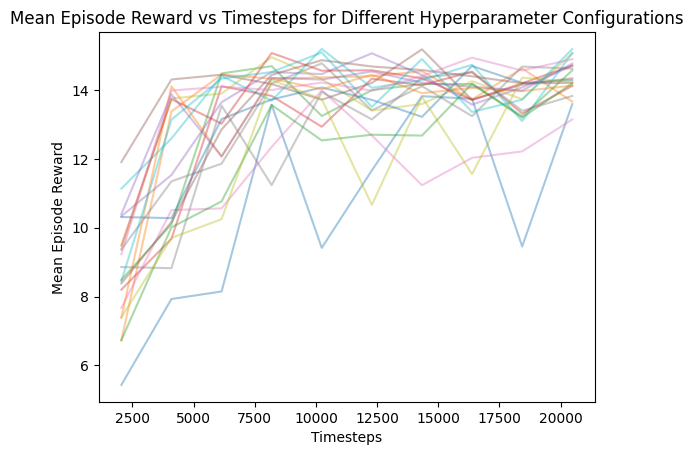

In [52]:
for training in training_improvements:
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Episode Reward")
    plt.title("Mean Episode Reward vs Timesteps for Different Hyperparameter Configurations")
    plt.plot(timesteps, training, alpha=0.4)

In [57]:
paired_results = list(zip(results[0::2], results[1::2]))
cleaned = []
for (mean_reward, cfg), details in paired_results:
    cleaned.append({
        "mean_reward": float(mean_reward),
        "config": cfg,
        "timesteps": details["timesteps"],
        "rewards": details["rewards"]
    })

In [60]:
cleaned

[{'mean_reward': 14.696505546569824,
  'config': {'learning_rate': 2.556596919624139e-05,
   'gamma': 0.9701224915536999,
   'gae_lambda': 0.8134027225281609,
   'clip_range': 0.10281887705749802,
   'ent_coef': 0.0005123585346704545},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(5.4356604),
   np.float32(7.929488),
   np.float32(8.14819),
   np.float32(13.568316),
   np.float32(9.414168),
   np.float32(11.663985),
   np.float32(13.817416),
   np.float32(13.741992),
   np.float32(9.45406),
   np.float32(13.586563)]},
 {'mean_reward': 14.696505546569824,
  'config': {'learning_rate': 0.0009501521466130236,
   'gamma': 0.9856944900564802,
   'gae_lambda': 0.9342904537365967,
   'clip_range': 0.14913801635101426,
   'ent_coef': 0.00017142719666042586},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(6.724963),
   np.float32(13.377451),
   np.float32(14.445068),
   np.float32(14.3

In [63]:
cleaned.sort(key=lambda x: x['mean_reward'], reverse=True)
top_configs = cleaned[:TOP_K]

In [64]:
top_configs

[{'mean_reward': 15.18957233428955,
  'config': {'learning_rate': 0.0008945840154296137,
   'gamma': 0.9874168093405197,
   'gae_lambda': 0.8231585189076716,
   'clip_range': 0.2412996615346996,
   'ent_coef': 0.00015489526447072226},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(9.371081),
   np.float32(13.751065),
   np.float32(13.894649),
   np.float32(14.95051),
   np.float32(14.313322),
   np.float32(13.400866),
   np.float32(13.590744),
   np.float32(14.251468),
   np.float32(13.731046),
   np.float32(15.065494)]},
 {'mean_reward': 15.18957233428955,
  'config': {'learning_rate': 0.0006852274864736559,
   'gamma': 0.9737181343612902,
   'gae_lambda': 0.8108684524005574,
   'clip_range': 0.12873082499968186,
   'ent_coef': 0.0007727241975326248},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(6.7370744),
   np.float32(10.010195),
   np.float32(10.763706),
   np.float32(13

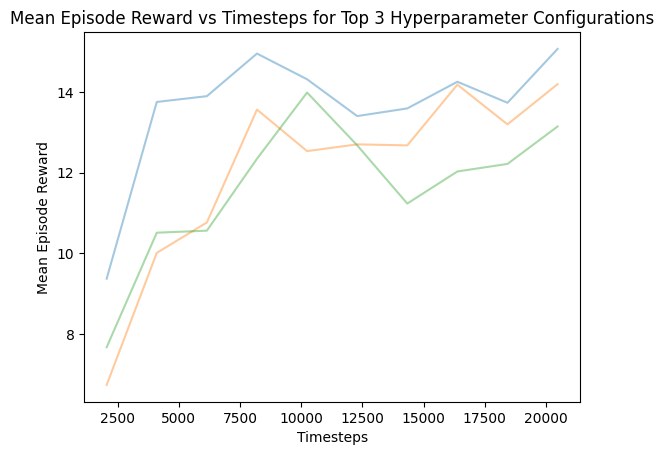

In [67]:
# plot the training curves for the top k configurations
plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.title("Mean Episode Reward vs Timesteps for Top 3 Hyperparameter Configurations")
for run in top_configs:
    rs = run['rewards']
    plt.plot(timesteps, rs, alpha=0.4)

In [5]:
top_configs = [{'mean_reward': 15.18957233428955,
  'config': {'learning_rate': 0.0008945840154296137,
   'gamma': 0.9874168093405197,
   'gae_lambda': 0.8231585189076716,
   'clip_range': 0.2412996615346996,
   'ent_coef': 0.00015489526447072226},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(9.371081),
   np.float32(13.751065),
   np.float32(13.894649),
   np.float32(14.95051),
   np.float32(14.313322),
   np.float32(13.400866),
   np.float32(13.590744),
   np.float32(14.251468),
   np.float32(13.731046),
   np.float32(15.065494)]},
 {'mean_reward': 15.18957233428955,
  'config': {'learning_rate': 0.0006852274864736559,
   'gamma': 0.9737181343612902,
   'gae_lambda': 0.8108684524005574,
   'clip_range': 0.12873082499968186,
   'ent_coef': 0.0007727241975326248},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(6.7370744),
   np.float32(10.010195),
   np.float32(10.763706),
   np.float32(13.56201),
   np.float32(12.532471),
   np.float32(12.699915),
   np.float32(12.674405),
   np.float32(14.179987),
   np.float32(13.1950865),
   np.float32(14.192329)]},
 {'mean_reward': 15.050933837890625,
  'config': {'learning_rate': 1.77076358602102e-05,
   'gamma': 0.9682015529719268,
   'gae_lambda': 0.8756533187950297,
   'clip_range': 0.2279719290162243,
   'ent_coef': 0.00024060340810620265},
  'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
  'rewards': [np.float32(7.672554),
   np.float32(10.510209),
   np.float32(10.560897),
   np.float32(12.342905),
   np.float32(13.98463),
   np.float32(12.676163),
   np.float32(11.23287),
   np.float32(12.0281925),
   np.float32(12.214973),
   np.float32(13.142862)]}]

In [10]:
def plot_long_training_curves(long_run_results, top_configs, output="topk_long_curves.png"):
    # Extract configs only
    top_cfgs = [item[1] for item in top_configs]

    plt.figure(figsize=(10, 6))

    for run in long_run_results:
        cfg = run["config"]
        if cfg in top_cfgs:
            ts = run["timesteps"]
            rs = run["rewards"]

            # Label includes seed and some hyperparams
            label = (
                f"lr={cfg['learning_rate']:.1e}, "
                f"clip={cfg['clip_range']:.2f}, "
                f"γ={cfg['gamma']:.3f}, "
                f"λ={cfg['gae_lambda']:.2f}, "
                f"seed={run['seed']}"
            )

            plt.plot(ts, rs, alpha=0.7, label=label)

    plt.title(f"Top-{len(top_cfgs)} PPO Configs (Long Training)")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Episode Reward (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output, dpi=200)
    plt.show()

 

long_run_results = []  # store all long-run curves

for element in top_configs:
    cfg = element['config']
    mean_r, std_r, curves = train_long(cfg, total_steps=40000)
    long_run_results.extend(curves)  # accumulate all seed curves
    print(f"Config #{rank}: long-run mean={mean_r:.2f}, std={std_r:.2f}")

plot_long_training_curves(long_run_results, top_configs)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.46     |
|    ep_rew_mean     | 7.94     |
| time/              |          |
|    fps             | 67       |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.31        |
|    ep_rew_mean          | 7.78        |
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.017862651 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.241       |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0345      |
|    learning

KeyError: 1

In [13]:
top_configs[0]

{'mean_reward': 15.18957233428955,
 'config': {'learning_rate': 0.0008945840154296137,
  'gamma': 0.9874168093405197,
  'gae_lambda': 0.8231585189076716,
  'clip_range': 0.2412996615346996,
  'ent_coef': 0.00015489526447072226},
 'timesteps': [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048],
 'rewards': [np.float32(9.371081),
  np.float32(13.751065),
  np.float32(13.894649),
  np.float32(14.95051),
  np.float32(14.313322),
  np.float32(13.400866),
  np.float32(13.590744),
  np.float32(14.251468),
  np.float32(13.731046),
  np.float32(15.065494)]}

In [18]:
long_run_results

[{'config': {'learning_rate': 0.0008945840154296137,
   'gamma': 0.9874168093405197,
   'gae_lambda': 0.8231585189076716,
   'clip_range': 0.2412996615346996,
   'ent_coef': 0.00015489526447072226},
  'seed': 0,
  'timesteps': [2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048,
   2048],
  'rewards': [np.float32(8.923805),
   np.float32(13.281668),
   np.float32(14.017421),
   np.float32(14.522825),
   np.float32(14.172421),
   np.float32(14.511714),
   np.float32(13.991155),
   np.float32(14.548747),
   np.float32(13.678221),
   np.float32(13.689333),
   np.float32(14.689493),
   np.float32(12.839582),
   np.float32(12.831102),
   np.float32(12.846552),
   np.float32(15.189572),
   np.float32(13.189252),
   np.float32(14.520103),
   np.float32(14.189412),
   np.float32(14.689493),
   np.float32(13.183696)]},
 {'config': {'learning_rate': 0.0008945840154296137,
   'gamma

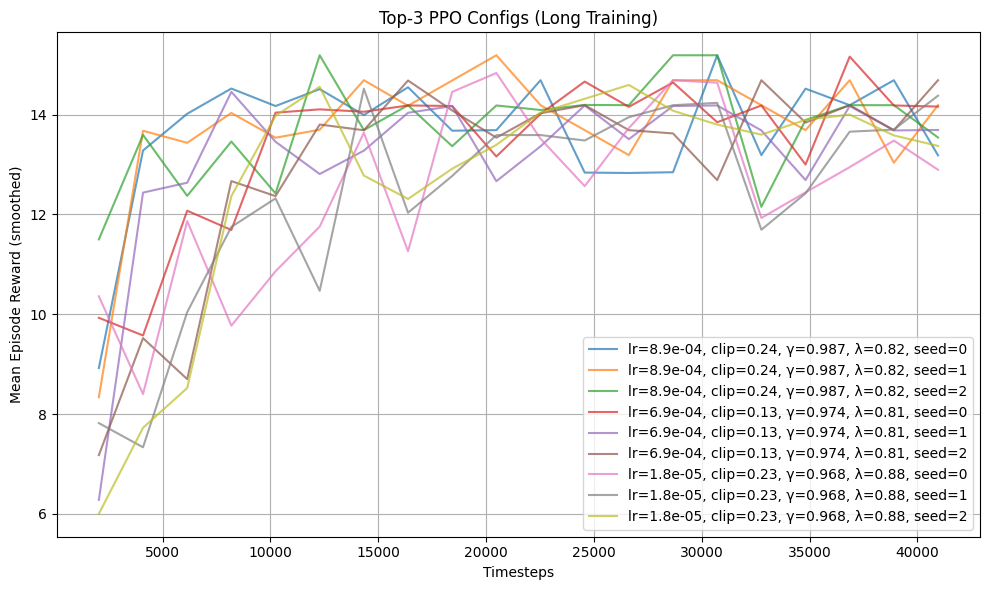

In [19]:


def plot_long_training_curves(long_run_results, top_configs, output="topk_long_curves.png"):
    # Extract configs only
    top_cfgs = [item['config'] for item in top_configs]

    plt.figure(figsize=(10, 6))

    for run in long_run_results:
        cfg = run["config"]
        if cfg in top_cfgs:
            ts = len(run["timesteps"])
            timesteps = []

            for i in range(ts):
                counter = 2048 * (i + 1)
                timesteps.append(counter)
            rs = run["rewards"]

            # Label includes seed and some hyperparams
            label = (
                f"lr={cfg['learning_rate']:.1e}, "
                f"clip={cfg['clip_range']:.2f}, "
                f"γ={cfg['gamma']:.3f}, "
                f"λ={cfg['gae_lambda']:.2f}, "
                f"seed={run['seed']}"
            )

            plt.plot(timesteps, rs, alpha=0.7, label=label)

    plt.title(f"Top-{len(top_cfgs)} PPO Configs (Long Training)")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Episode Reward (smoothed)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output, dpi=200)
    plt.show()

plot_long_training_curves(long_run_results, top_configs)